In [306]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.ops import split
from matplotlib.dates import DateFormatter
from shapely.geometry import LineString, Point

GLACIERS = ["DJ", "UI"]

terminus_boxes = gpd.read_file("../data/terminus/terminus_boxes.geojson")
terminus_positions = gpd.read_file("../data/terminus/terminus_traces_1978_2023.geojson")

out = []

for glacier in GLACIERS:
    print(f"Working on {glacier}")

    box = terminus_boxes[terminus_boxes["glacier_code"] == glacier].reset_index()
    traces = terminus_positions[terminus_positions["glacier_code"] == glacier]

    traces = traces.sort_values(by=["date"], ascending=False)

    for index, trace in traces.iterrows():
        difference = split(box.geometry[0], trace.geometry.geoms[0])

        start_relocate_distance = None
        end_relocate_distance = None

        if len(difference.geoms) == 1:
            trace_line = trace.geometry.geoms[0]
            trace_start = trace_line.coords[0]
            trace_end = trace_line.coords[-1]

            # # INITIAL STATE PLOT
            # fig, ax = plt.subplots()
            # x, y = box.geometry[0].geoms[0].exterior.xy
            # plt.plot(x, y, color="blue", alpha=0.5)
            # x, y = trace.geometry.geoms[0].xy
            # plt.plot(x, y, color="orange", alpha=0.5)
            # x, y = trace_start
            # plt.plot(x, y, color="green", marker="o", alpha=0.5)
            # x, y = trace_end
            # plt.plot(x, y, color="red", marker="o", alpha=0.5)
            # plt.title(f"initial: {index}; {trace.date}")
            # plt.show()

            nearest_start = (
                box.geometry[0]
                .geoms[0]
                .exterior.interpolate(
                    box.geometry[0].geoms[0].exterior.project(Point(trace_start))
                )
            )
            nearest_end = (
                box.geometry[0]
                .geoms[0]
                .exterior.interpolate(
                    box.geometry[0].geoms[0].exterior.project(Point(trace_end))
                )
            )

            if box.geometry[0].geoms[0].contains(Point(trace_start)):
                start_relocate_distance = nearest_start.distance(Point(trace_start))
                start_edge = (
                    box.geometry[0]
                    .geoms[0]
                    .exterior.interpolate(
                        box.geometry[0].geoms[0].exterior.project(nearest_start) - 50
                    )
                )
                start_vec = np.array(nearest_start.coords[0]) - np.array(start_edge.coords[0])
                start_perpendicular = (start_vec[1], -start_vec[0]) / np.linalg.norm(start_vec)
                trace_start_moved = (
                    nearest_start.x - start_perpendicular[0] * 50,
                    nearest_start.y - start_perpendicular[1] * 50,
                )
            else:
                trace_start_moved = trace_start

            if box.geometry[0].geoms[0].contains(Point(trace_end)):
                end_relocate_distance = nearest_end.distance(Point(trace_end))
                end_edge = (
                    box.geometry[0]
                    .geoms[0]
                    .exterior.interpolate(
                        box.geometry[0].geoms[0].exterior.project(nearest_end) + 50
                    )
                )
                end_vec = np.array(nearest_end.coords[0]) - np.array(end_edge.coords[0])
                end_perpendicular = (end_vec[1], -end_vec[0]) / np.linalg.norm(end_vec)
                trace_end_moved = (
                    nearest_end.x + end_perpendicular[0] * 50,
                    nearest_end.y + end_perpendicular[1] * 50,
                )
            else:
                trace_end_moved = trace_end

            trace_line_extended = list(trace_line.coords)
            trace_line_extended[0] = trace_start_moved
            trace_line_extended[-1] = trace_end_moved
            trace_line_extended = LineString(trace_line_extended)

            # # EXTENDED LINE PLOT
            # fig, ax = plt.subplots()
            # x, y = box.geometry[0].geoms[0].exterior.xy
            # plt.plot(x, y, color="blue", alpha=0.5)
            # x, y = trace_line_extended.xy
            # plt.plot(x, y, color="green", alpha=0.5)
            # plt.title(f"extended: {index}; {trace.date}")
            # plt.show()

            difference = split(box.geometry[0], trace_line_extended)

            # # CLOSED BOX PLOT
            # fig, ax = plt.subplots()
            # x, y = difference.geoms[1].exterior.xy
            # plt.plot(x, y, color="blue", alpha=0.5)
            # plt.title(f"difference: {index}; {trace.date}")
            # plt.show()

        difference_gdf = trace.drop(labels=["geometry"])
        difference_gdf["geometry"] = difference.geoms[1]
        difference_gdf["area"] = difference.geoms[1].area
        difference_gdf["area_width_averaged"] = difference.geoms[1].area / box.width[0]
        difference_gdf["start_relocated"] = start_relocate_distance
        difference_gdf["end_relocated"] = end_relocate_distance
        difference_gdf = gpd.GeoDataFrame(difference_gdf).transpose().set_geometry("geometry")
        difference_gdf.set_crs(terminus_positions.crs, inplace=True)

        out.append(difference_gdf)

out_gdf = pd.concat(out, ignore_index=True)
out_gdf = out_gdf.sort_values(by=["glacier_code", "date"])
out_gdf = out_gdf[out_gdf["date"] > "1980-01-01"]
out_gdf["area_width_averaged_change"] = out_gdf["area_width_averaged"] - out_gdf.groupby(
    ["glacier_code"]
)["area_width_averaged"].transform("first")
# out_gdf.to_file("../data/terminus/terminus_boxes_1978_2023.geojson", driver="GeoJSON")

Working on DJ
Working on UI


In [312]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

out_gdf = out_gdf[out_gdf["date"] > "1980-01-01"]
out_gdf["date"] = pd.to_datetime(out_gdf["date"])
out_gdf["area_width_averaged_change"] = out_gdf["area_width_averaged_change"] / 1000
data_1985_2010 = out_gdf[(out_gdf["date"] >= "1978-01-01") & (out_gdf["date"] < "2010-01-01")]
data_2010_2023 = out_gdf[(out_gdf["date"] >= "2010-01-01") & (out_gdf["date"] <= "2024-01-01")]

plt.rcParams["axes.labelsize"] = 18
plt.rcParams["figure.dpi"] = 1000
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["axes.xmargin"] = 0

fig, ax = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={"width_ratios": [1, 2]})

for glacier in GLACIERS:
    glacier_data = data_1985_2010[data_1985_2010["glacier_code"] == glacier]
    ax[0].plot(
        glacier_data["date"],
        glacier_data["area_width_averaged_change"],
        label=glacier,
        marker="o",
        linewidth=1,
        markersize=1.25,
    )

for glacier in GLACIERS:
    glacier_data = data_2010_2023[data_2010_2023["glacier_code"] == glacier]
    ax[1].plot(
        glacier_data["date"],
        glacier_data["area_width_averaged_change"],
        label=glacier,
        marker="o",
        linewidth=1,
        markersize=1.25,
    )

xmin = pd.to_datetime("1985-01-01")
xmax = pd.to_datetime("2010-01-01")
ax[0].set_xlim(xmin, xmax)
ax[0].set_ylabel("Relative terminus position [km]", labelpad=20)
ax[0].legend(frameon=False)
ax[0].axhline(y=0, c="black", alpha=0.7, linewidth=0.7, zorder=1, linestyle=(0, (6, 8)))
ax[0].xaxis.set_major_locator(mdates.YearLocator(base=5))
ax[0].xaxis.set_minor_locator(mdates.YearLocator(1))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax[0].tick_params(axis="x", rotation=70)
ax[0].grid(
    True,
    which="major",
    axis="both",
    color="gray",
    linestyle="dotted",
    linewidth=0.5,
    alpha=0.8,
    zorder=0,
)

xmin = pd.to_datetime("2010-01-01")
xmax = pd.to_datetime("2024-01-01")
ax[1].set_xlim(xmin, xmax)
ax[1].tick_params(labelleft=False)
ax[1].axhline(y=0, c="black", alpha=0.7, linewidth=0.7, zorder=1, linestyle=(0, (6, 8)))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax[1].xaxis.set_minor_locator(mdates.YearLocator(1))
ax[1].tick_params(axis="x", rotation=70)
ax[1].grid(
    True,
    which="both",
    axis="both",
    color="gray",
    linestyle="dotted",
    linewidth=0.5,
    alpha=0.8,
    zorder=0,
)

# Set the same Y-axis range for both plots
ymin = min(
    data_1985_2010["area_width_averaged_change"].min(),
    data_2010_2023["area_width_averaged_change"].min(),
)
ymax = max(
    data_1985_2010["area_width_averaged_change"].max(),
    data_2010_2023["area_width_averaged_change"].max(),
)
ax[0].set_ylim(ymin, ymax)
ax[1].set_ylim(ymin, ymax)

plt.tight_layout()
plt.savefig("../data/terminus/terminus_boxes_1978_2023.png", dpi=fig.dpi)
plt.show()

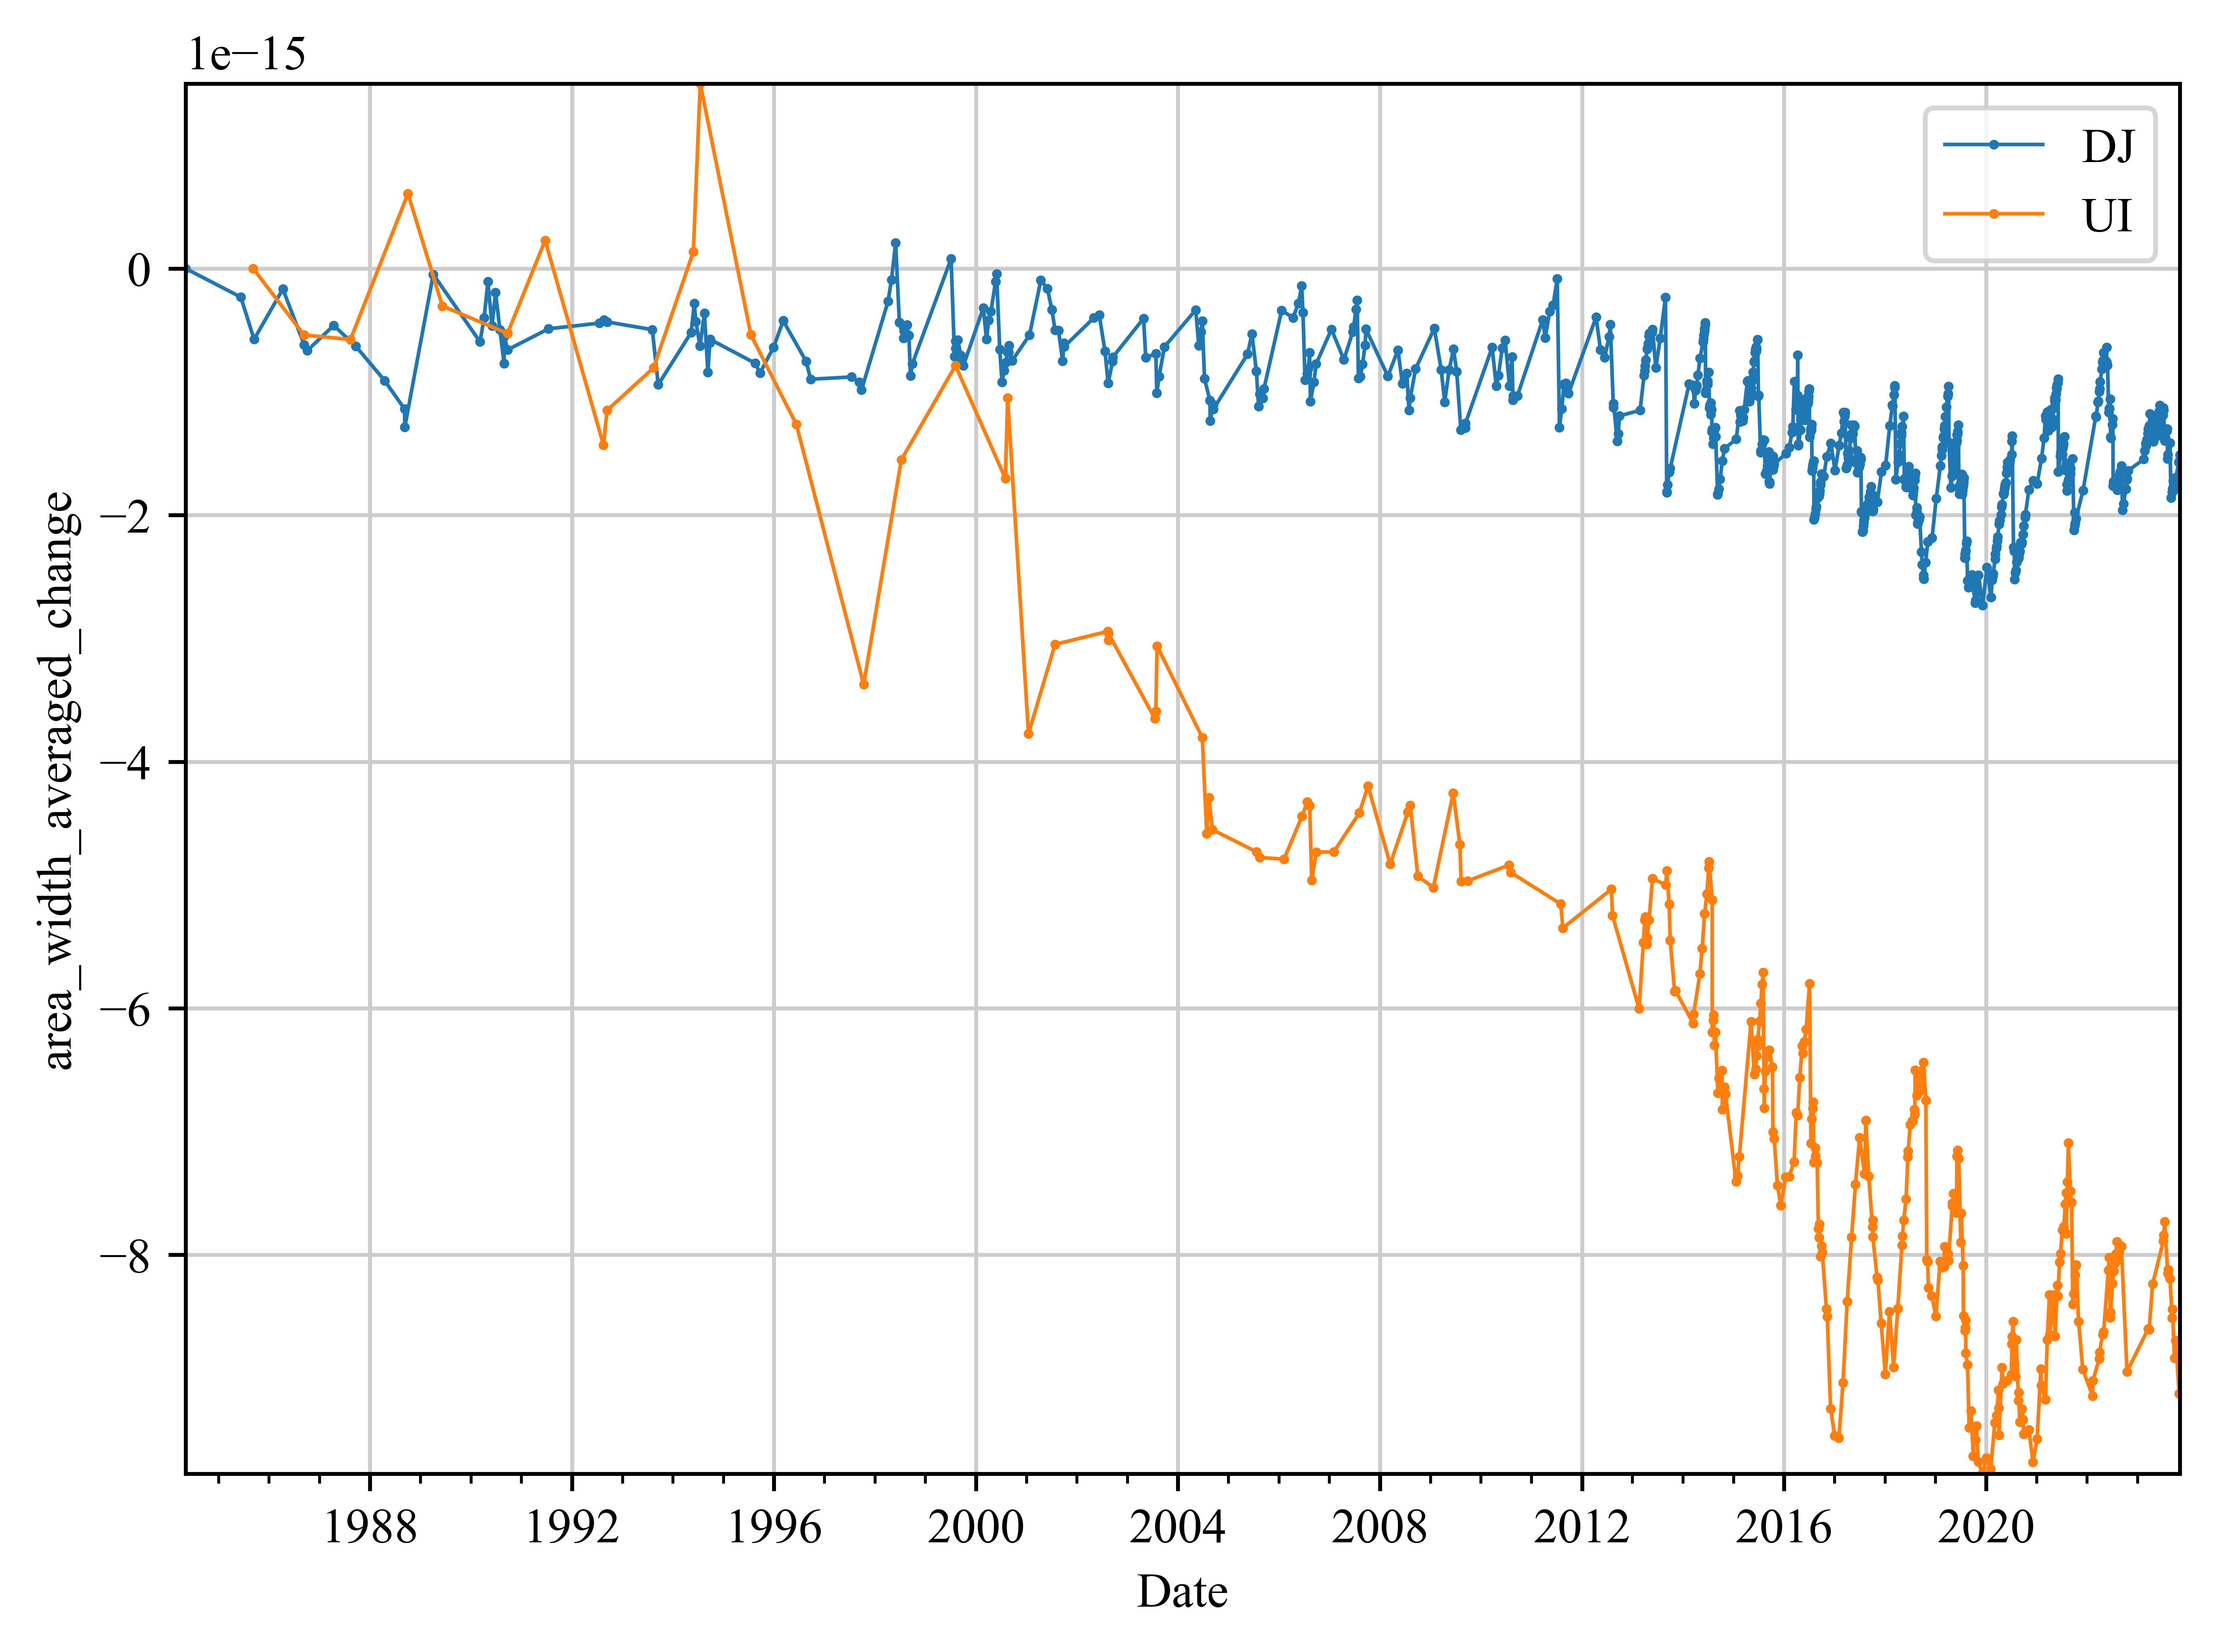

In [313]:
# PLOTTING

# Defines plot settings
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["figure.dpi"] = 1000
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 10
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10

# out_gdf = out_gdf[out_gdf["date"] > "2010-01-01"]
out_gdf["date"] = pd.to_datetime(out_gdf["date"])

for glacier in GLACIERS:
    glacier_data = out_gdf[out_gdf["glacier_code"] == glacier]
    plt.plot(
        glacier_data["date"],
        glacier_data["area_width_averaged_change"],
        label=glacier,
        marker="o",
        linewidth=0.75,
        markersize=1,
    )

plt.xlabel("Date")
plt.ylabel("area_width_averaged_change")
plt.legend()
plt.axhline(y=0, c="black", alpha=0.5, linewidth=0.5, zorder=0)
plt.gca().xaxis.set_major_formatter(DateFormatter("%Y"))
# plt.xticks(rotation=45)
plt.tight_layout()
plt.gca().xaxis.set_minor_locator(plt.matplotlib.dates.YearLocator(1))

# plt.xlim(pd.Timestamp("2010-01-01"), pd.Timestamp("2022-01-01"))

plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import pandas as pd

GLACIERS = ["DJ", "UI"]

terminus_boxes = gpd.read_file("../data/terminus/terminus_boxes.geojson").to_crs(epsg=3413)
terminus_positions = gpd.read_file(
    "../data/terminus/terminus_traces_1978_2023.geojson"
).to_crs(epsg=3413)

# Convert 'date' column to datetime objects
terminus_positions["date"] = pd.to_datetime(terminus_positions["date"])

fig, axs = plt.subplots(len(GLACIERS), 1, figsize=(10, 10), sharex=True)

for i, glacier in enumerate(GLACIERS):
    print(f"Working on {glacier}")

    box = terminus_boxes[terminus_boxes["glacier_code"] == glacier].reset_index()
    traces = terminus_positions[terminus_positions["glacier_code"] == glacier]

    # Sort traces by date in descending order
    traces = traces.sort_values(by=["date"])

    # Normalize dates for coloring
    norm = Normalize(
        vmin=terminus_positions["date"].min().timestamp(),
        vmax=terminus_positions["date"].max().timestamp(),
    )
    mapper = ScalarMappable(norm=norm, cmap="viridis")

    for index, trace in traces.iterrows():
        color = mapper.to_rgba(trace["date"].timestamp())

        # Access coordinates directly from LineString geometry
        x, y = trace.geometry.geoms[0].xy

        axs[i].plot(
            x,  # Access x coordinates
            y,  # Access y coordinates
            color=color,
            alpha=0.5,
        )

    axs[i].set_title(f"Glacier {glacier}")
    axs[i].set_ylabel("Y")
    axs[i].set_xlabel("X")

    # Set CRS for axes
    axs[i].set_aspect("equal")
    axs[i].set_xlim(box.total_bounds[0], box.total_bounds[2])
    axs[i].set_ylim(box.total_bounds[1], box.total_bounds[3])
    axs[i].set_xlabel("X (m)")
    axs[i].set_ylabel("Y (m)")

# Add colorbar
cbar = fig.colorbar(mapper, ax=axs.ravel().tolist(), orientation="vertical")
cbar.set_label("Date")

plt.tight_layout()
plt.show()